# Distracted Driver Detection

## Project Overview

#### In this peoject, it gives driver images which were taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). The goal is to predict the likelihood of what the driver is doing in each picture. 

#### The project is essentially a supervised classification learning problem. The training dataset is already well labeled for classification. The goal of the model is to learn the features of different driving behaviours such that an unseen driving picture can be correctly identified.

## Ideas

#### Since the project is a classification task, there are many good, established networks for classification tasks, such as MobileNet, VGG, ResNet and so on. Based on the principles of migration learning, I decided to use the MobileNet2 network here, freezing the underlying neurons and modifying only the top layer to make it fit our project requirements.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3' #use the first and second GPU

config = tf.compat.v1.ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 0.8 # Programs can only use up to 80% of the graphics memory of a given gpu

config.gpu_options.allow_growth = True #Programs request memory on demand

sess = tf.compat.v1.Session(config=config)

## Data analysis 

In [36]:
# The way to training and validation datasets in the dataset
ROOT_DIR = "E:\code\kaggle\driver\imgs"
train_dir = os.path.join(ROOT_DIR, 'train')
valid_dir = os.path.join(ROOT_DIR, 'valid')

#### The dataset consists of a training set and a test set, all of which are still images taken from the in-car camera footage. The training set has been classified based on the label-classes [c0,...,c9], the meanings of which are: -c0:driving safely; -c1:typing with right hand; -c2:talking on the phone with right hand; -c3:typing with left hand; -c4:talking on the phone with left hand; -c5:tuning the radio; -c6:drinking a drink; -c7:taking the back things; -c8:fixing hair and make-up; -c9:talking to other passengers.


In [27]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [28]:
dir = '../data/'

driver_imgs_list_path = os.path.join(dir, 'driver_imgs_list.csv')
driver_imgs_list = pd.read_csv(driver_imgs_list_path)

<AxesSubplot:xlabel='count', ylabel='classname'>

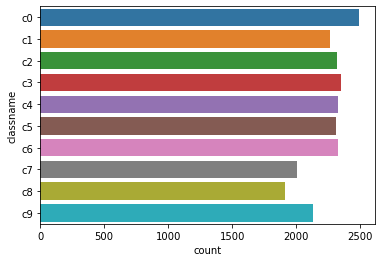

In [33]:
sns.countplot(y='classname', data=driver_imgs_list)

<AxesSubplot:xlabel='count', ylabel='subject'>

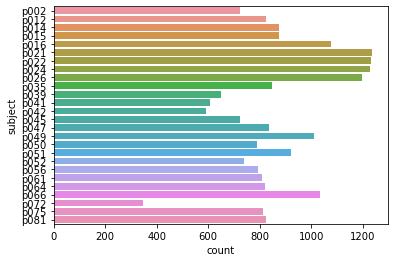

In [34]:
sns.countplot(y='subject', data=driver_imgs_list)

#### The images in the training set with the same classification are in the same folder and the distribution of the number of images in each classification is shown in the figure above. The test set was not classified and contained a total of 79,721 2D images. In addition to the dataset, the project also provided a list of driver ids, which contains the driver ids of the images in the dataset and the corresponding classifications. A sample of the randomly extracted images is shown below.

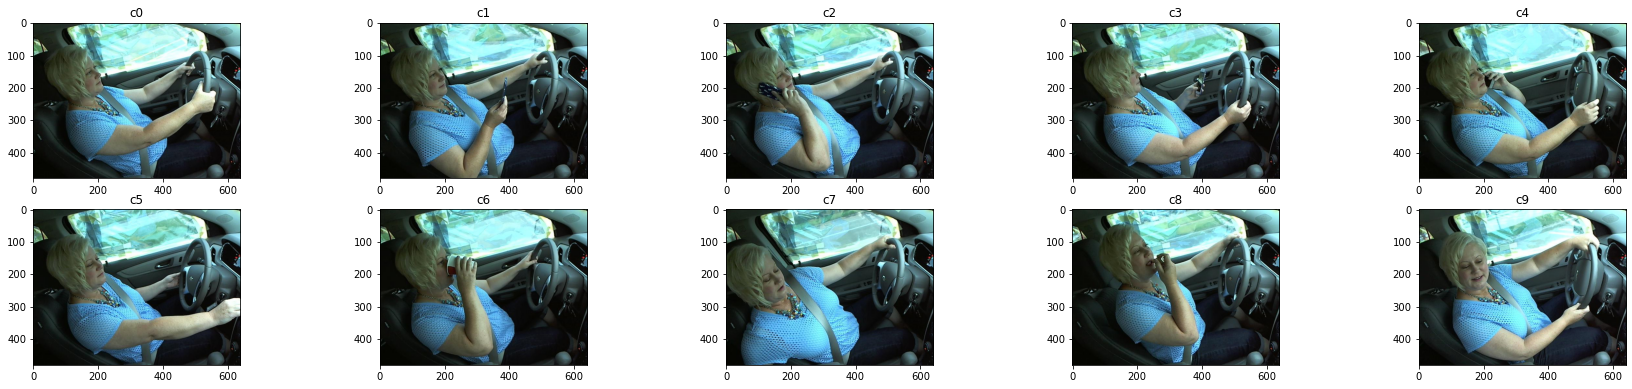

In [35]:
dir1 = '../data/imgs/train/'
img1 = []

for i in range(10):
    classname = 'c%d'%i
    df = driver_imgs_list[(driver_imgs_list['subject']=='p042') & (driver_imgs_list['classname']== classname)].iloc[2]
    img_path = os.path.join(dir1,df.values[1],df.values[2])
    img1.append(img_path)

plt.figure(figsize = (30,20))
for i in range(10):
    plt.subplot(6,5,i+1)
    img2 = cv2.imread(img1[i])
    img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.title('c%d'%i)
    plt.imshow(img3)
plt.savefig('../picture/Distracted driver detection.png')

## Data preprocess and model training

#### First, set the size of the picture. Since we only have 30 images per category in our validation set, we set the batch size here to be smaller, just set it to 10. Then Use buffer preceding images from disk to avoid I / O blocking. ref:: https://tensorflow.google.cn/guide/data_performanc
#### Although the data is pre-processed, it is not enough to feed the model directly and must be augmentationed. Here I used the random flip and random rotation. The data also went through preprocess before entering MobileNetV2. 

In [39]:
# The default file name is the name of our category
class_names = train_dataset.class_names
num_classes = len(class_names)

In [40]:
# Use buffer preceding images from disk to avoid I / O blocking
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
# Augmentation the data
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Then, create the base model from the pre-trained model MobileNet V2. Constructing the model and load pre-trained base model and pre-trained weights. Stacking classification layers on top. The first layer is the global average pooling layer, ref:: https://www.cnblogs.com/hutao722/p/10008581.html.
#### And then, set the perdiction layer. Apply the tf.keras.layers.Dense layer to convert these features into one prediction per image. Before training the model, it needs to be compiled. And we need to define the input, loss functin, learning rate and optimizer. We also need to freeze all the layers before the fine_tune_at layer, and only train the top 100 of the data.

In [42]:
# Data goes through preprocess_input before entering MobileNetV2
# Keep the pixels in[-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Output layer
# prediction_layer = tf.keras.layers.Dense(num_classes)

In [43]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [44]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [45]:
# Freeze the convolution
base_model.trainable = False

In [49]:
# Input
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [50]:
# Train the MobileNetV2
base_model.trainable = True
# But we only want to train the top 100 of the data
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

#### Finally, start training. After 10 cycles of training, an accuracy of approximately 94% can be seen on the validation set. We can see that the loss and accuracy are both have a normal trend of change. We can also visualise this trend of change.

In [18]:
# start training
total_epochs =  10
history = model.fit(train_dataset,
                    epochs=total_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
692/692 [==============================] - 159s 191ms/step - loss: 2.1417 - accuracy: 0.2429 - val_loss: 1.2367 - val_accuracy: 0.5952
Epoch 2/10
692/692 [==============================] - 69s 99ms/step - loss: 1.1528 - accuracy: 0.6101 - val_loss: 0.7191 - val_accuracy: 0.7699
Epoch 3/10
692/692 [==============================] - 67s 96ms/step - loss: 0.7306 - accuracy: 0.7516 - val_loss: 0.4968 - val_accuracy: 0.8448
Epoch 4/10
692/692 [==============================] - 68s 97ms/step - loss: 0.5136 - accuracy: 0.8281 - val_loss: 0.4287 - val_accuracy: 0.8597
Epoch 5/10
692/692 [==============================] - 81s 116ms/step - loss: 0.3947 - accuracy: 0.8701 - val_loss: 0.2905 - val_accuracy: 0.9129
Epoch 6/10
692/692 [==============================] - 71s 101ms/step - loss: 0.3180 - accuracy: 0.8981 - val_loss: 0.2710 - val_accuracy: 0.9160
Epoch 7/10
692/692 [==============================] - 66s 95ms/step - loss: 0.2603 - accuracy: 0.9175 - val_loss: 0.2133 - val_accur

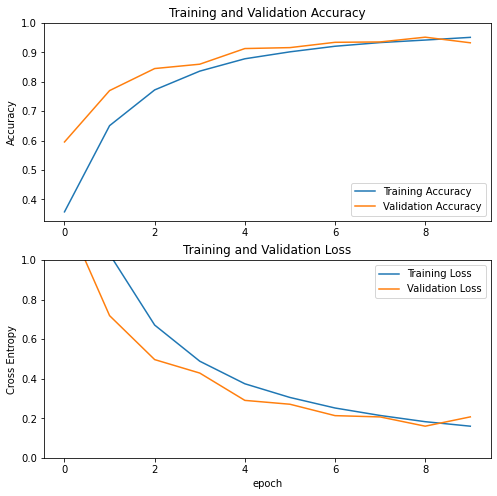

In [20]:
# Take a look at the learning curve for training and validation accuracy/loss 
# when using the MobileNet V2 base model as a fixed feature extraction procedure.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### The model that was trained will be stored. This model can now be used to predict whether a driver is distracted or not.

In [21]:
# set the path to save model
MODEL_DIR = "./models/"
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)

In [22]:
# save the model
h5_dir = os.path.join(MODEL_DIR, 'ddd_mobilenet_v2_2.h5')
model.save(h5_dir)

## Brief reflection

#### In this project, I learned that simple CNN models are not capable of handling multi-classification problems with such large databases, it is straightforward to use pre-trained models for training and data testing, and to determine optimization solutions. In this process I read the best examples from the kaggle competition, and the official documents of tensorflor. I also learned how to perform migration learning and fine-tune the model. I also dealt with a number of problems with setting up the environment, such as finding a suitable version for libraries used.